In [1]:
import pandas as pd
import keras
import numpy as np
import os
from tqdm import tqdm
from time import time
from sklearn.metrics import roc_curve,roc_auc_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,KFold
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image,ImageOps
import glob 
import cv2
import pickle
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 1.x
except Exception:
  pass

TensorFlow is already loaded. Please restart the runtime to change versions.


In [2]:
import tensorflow as tf

In [3]:
os.chdir("/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets/")
!pwd

/content/drive/Shared drives/ECS 289G Deep Learning Project/Project/Datasets


In [4]:
!ls

 bin_files			        images_pickled
'csv files'			        images_zip_files
 Data_Entry_2017_v2020.gsheet	       'Process NIH Dataset Details.ipynb'
'Filter and Create Sample Sets.ipynb'  'Sample Set Images.ipynb'
 images


In [5]:
df = pd.read_csv("csv files/no_sampling_index_csv/df_AP.csv")
df = df.iloc[:,:-1]

In [6]:
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168
1,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,55,F,AP,2500,2048,0.168,0.168
2,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168
3,00000032_003.png,No Finding,3,32,55,F,AP,2500,2048,0.168,0.168
4,00000032_004.png,Edema,4,32,55,F,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
5376,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139
5377,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139
5378,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139
5379,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139


In [7]:
df_final = pd.DataFrame(columns=df.columns)
for _,record in df.iloc[:,:].iterrows():
  rec = record.copy(deep=True)
  if '|' in str(record['Finding Labels']):
    labels = str(record['Finding Labels']).split('|')
    for label in labels:
      rec['Finding Labels'] = label
      df_final= df_final.append(rec,ignore_index=True)
  else:
    df_final = df_final.append(record,ignore_index=True)

df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
5632,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139
5633,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139
5634,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139
5635,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139


In [8]:
my_glob = glob.glob('images/images*/*.png')
print('Number of Observations: ', len(my_glob)) # Number of photos should equal 112,120

Number of Observations:  112121


In [9]:
my_glob[:100]

['images/images2/00003797_000.png',
 'images/images2/00003794_000.png',
 'images/images2/00003798_000.png',
 'images/images2/00003799_000.png',
 'images/images2/00003799_002.png',
 'images/images2/00003799_001.png',
 'images/images2/00003799_003.png',
 'images/images2/00003799_004.png',
 'images/images2/00003799_005.png',
 'images/images2/00003799_006.png',
 'images/images2/00003799_007.png',
 'images/images2/00003801_000.png',
 'images/images2/00003801_001.png',
 'images/images2/00003802_000.png',
 'images/images2/00003800_000.png',
 'images/images2/00003802_001.png',
 'images/images2/00003802_002.png',
 'images/images2/00003801_002.png',
 'images/images2/00003802_003.png',
 'images/images2/00003802_004.png',
 'images/images2/00003803_000.png',
 'images/images2/00003803_004.png',
 'images/images2/00003803_001.png',
 'images/images2/00003803_003.png',
 'images/images2/00003803_002.png',
 'images/images2/00003803_006.png',
 'images/images2/00003803_005.png',
 'images/images2/00003803_00

In [10]:
full_img_paths = {os.path.basename(x): x for x in my_glob}
df_final['full_path'] = df_final['Image Index'].map(full_img_paths.get)

In [11]:
df_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_002.png
...,...,...,...,...,...,...,...,...,...,...,...,...
5632,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,images/images12/00030770_001.png
5633,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,images/images12/00030770_002.png
5634,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,images/images12/00030772_000.png
5635,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,images/images12/00030772_001.png


In [12]:
df_final.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'full_path'],
      dtype='object')

In [13]:
df_final.to_csv("csv files/no_sampling_index_csv/added_paths_AP.csv",index=False)

                    Finding Labels
No Finding                    2240
Infiltration                   993
Effusion                       559
Atelectasis                    531
Consolidation                  303
Nodule                         223
Mass                           172
Edema                          141
Cardiomegaly                   125
Pneumothorax                   115
Pleural_Thickening              80
Pneumonia                       71
Fibrosis                        46
Emphysema                       37
Hernia                           1


(<matplotlib.axes._subplots.AxesSubplot at 0x7fab16112be0>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  <a list of 15 Text major ticklabel objects>))

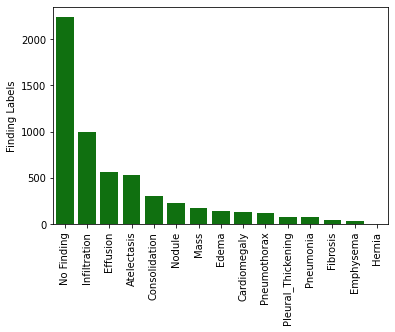

In [14]:
#Frequency distribution for the labels
count_per_unique_label = df_final['Finding Labels'].value_counts()
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes

print(df_count_per_unique_label) # view tabular results
sns.barplot(x = df_count_per_unique_label.index[:], y="Finding Labels", data=df_count_per_unique_label[:], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

## **Train/ Test/ Validation Dataset**

Referenced from

1.   https://www.kaggle.com/redwankarimsony/nih-chest-x-ray8-classifier-cnn-visualization
2.   https://www.kaggle.com/adamjgoren/nih-chest-x-ray-multi-classification




In [15]:
df = pd.read_csv("csv files/no_sampling_index_csv/added_paths_AP.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path
0,00000032_000.png,Cardiomegaly,0,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_000.png
1,00000032_001.png,Cardiomegaly,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
2,00000032_001.png,Edema,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
3,00000032_001.png,Effusion,1,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_001.png
4,00000032_002.png,No Finding,2,32,55,F,AP,2500,2048,0.168,0.168,images/images1/00000032_002.png


In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = (256,256)
TRAIN_SIZE = 2000
VAL_SIZE = 1000
TEST_SIZE = 400

In [18]:

#1. Break into train-val-test datasets (DONE)
#2. Then, we need to work on getting the image repr of each image (DONE)
#3. seperate into x_train,x_test,y_train,y_test like our HW (DONE)
#4. Develop a simple CNN model for image prediction (DONE)
#5. Write a model function (DONE)
#6. Then have a 5 fold CV for the CNN and then have ROC, PR, Accuracy, F1 scores and confusion matrix

In [19]:
with open("csv files/train_val_list.txt",'r') as f:
  train_links = [line.strip() for line in f.readlines()]
  train_links = np.array(train_links).astype(str)

print(f"Number of train_samples: {len(train_links)}")
train_links[:10]

Number of train_samples: 86524


array(['00000001_000.png', '00000001_001.png', '00000001_002.png',
       '00000002_000.png', '00000004_000.png', '00000005_000.png',
       '00000005_001.png', '00000005_002.png', '00000005_003.png',
       '00000005_004.png'], dtype='<U16')

In [21]:
with open("csv files/test_list.txt",'r') as f:
  test_links = [line.strip() for line in f.readlines()]
  test_links = np.array(test_links).astype(str)
print(f"Number of test_samples: {len(test_links)}")
test_links[:10]

Number of test_samples: 25596


array(['00000003_000.png', '00000003_001.png', '00000003_002.png',
       '00000003_003.png', '00000003_004.png', '00000003_005.png',
       '00000003_006.png', '00000003_007.png', '00000013_000.png',
       '00000013_001.png'], dtype='<U16')

In [22]:
df_train = df[df['Image Index'].isin(train_links)]
df_test = df[df['Image Index'].isin(test_links)]

In [23]:
df_train = df[df['Image Index'].isin(train_links)]
df_test = df[df['Image Index'].isin(test_links)]

In [24]:
val_split = 0.1 #last 10% of the train data
num_train_overall = df_train.shape[0]
df_train_final = df_train.iloc[:-int(val_split * num_train_overall),:]
df_val = df_train.iloc[-int(val_split * num_train_overall):,:]


In [25]:
classes = ['No Finding','Infiltration',
           'Effusion','Atelectasis','Nodule', 'Mass',
           'Pleural_Thickening','Fibrosis','Pneumothorax',
           'Cardiomegaly','Consolidation','Emphysema',
           'Pneumonia','Hernia','Edema']

mapper = dict(zip(classes, range(0,len(classes))))
mapper

{'Atelectasis': 3,
 'Cardiomegaly': 9,
 'Consolidation': 10,
 'Edema': 14,
 'Effusion': 2,
 'Emphysema': 11,
 'Fibrosis': 7,
 'Hernia': 13,
 'Infiltration': 1,
 'Mass': 5,
 'No Finding': 0,
 'Nodule': 4,
 'Pleural_Thickening': 6,
 'Pneumonia': 12,
 'Pneumothorax': 8}

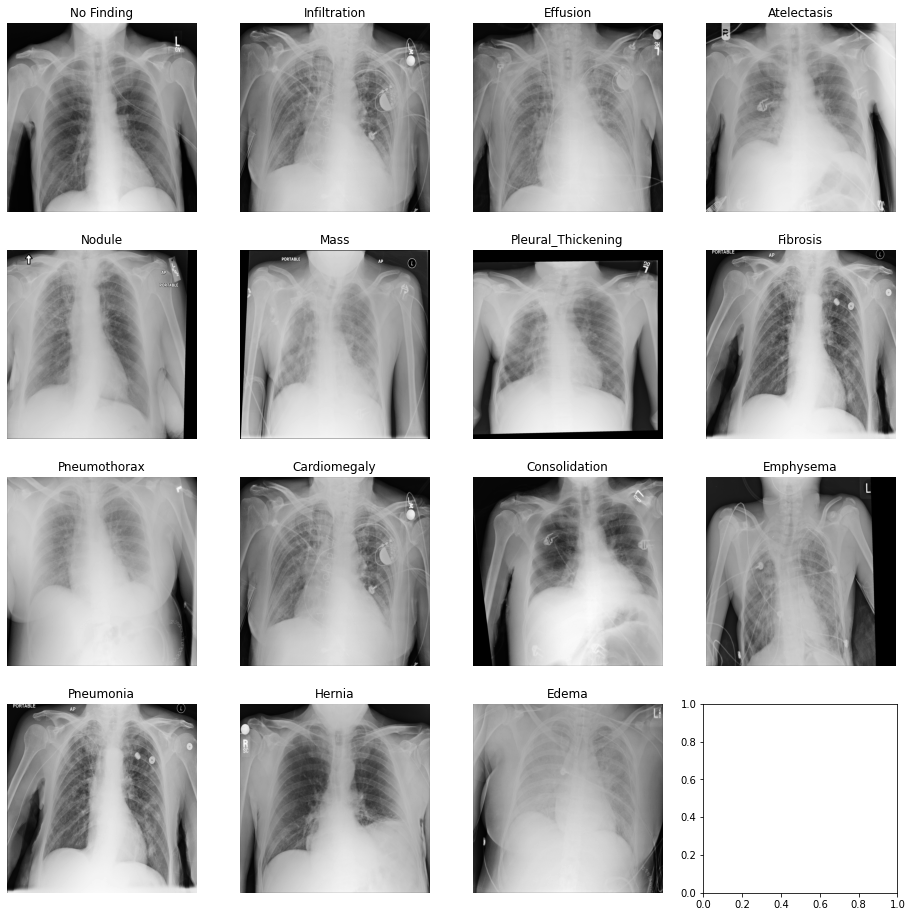

In [26]:
#plot random samples for each class in a subplot basis
fig, axs = plt.subplots(nrows=4,ncols=4,figsize = (16, 16))
for cl in mapper.keys():
  i = mapper[cl] // 4
  j = mapper[cl] % 4
  sample = df_train_final[df_train_final['Finding Labels'] == cl].iloc[0,:]
  path = sample['full_path']
  image = mpimg.imread(path)
  axs[i,j].imshow(image,cmap="gray")
  axs[i,j].set_title(cl)
  axs[i,j].axis('off')

In [27]:
for cl in classes:
  df_train_final[cl] = df_train_final['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_val[cl] = df_val['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)
  df_test[cl] = df_test['Finding Labels'].map(lambda result: 1.0 if cl in result else 0)


df_train_final['target_vector'] = df_train_final.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_val['target_vector'] = df_val.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])
df_test['target_vector'] = df_test.apply(lambda target: [target[classes].values], 1).map(lambda target: target[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [28]:
#TRAIN WITH TRAIN SIZE SAMPLES
df_train_final = df_train_final.iloc[:TRAIN_SIZE,:]
df_val = df_val.iloc[:VAL_SIZE,:]

In [29]:
df_test = df_test.iloc[-TEST_SIZE:,:]

In [30]:
df_train_final

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
112,00000156_000.png,Cardiomegaly,0,156,81,M,AP,2500,2048,0.171,0.171,images/images1/00000156_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
113,00000156_000.png,Infiltration,0,156,81,M,AP,2500,2048,0.171,0.171,images/images1/00000156_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
114,00000156_001.png,Cardiomegaly,1,156,81,M,AP,2500,2048,0.171,0.171,images/images1/00000156_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
115,00000156_001.png,Effusion,1,156,81,M,AP,2500,2048,0.171,0.171,images/images1/00000156_001.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
116,00000179_000.png,No Finding,0,179,63,M,AP,2500,2048,0.168,0.168,images/images1/00000179_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,00011619_002.png,Effusion,2,11619,30,M,AP,2500,2048,0.168,0.168,images/images6/00011619_002.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2553,00011619_002.png,Cardiomegaly,2,11619,30,M,AP,2500,2048,0.168,0.168,images/images6/00011619_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2554,00011619_003.png,No Finding,3,11619,30,M,AP,2500,2048,0.168,0.168,images/images6/00011619_003.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2555,00011619_004.png,No Finding,4,11619,30,M,AP,2500,2048,0.168,0.168,images/images6/00011619_004.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [31]:
df_val

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
4926,00028583_004.png,No Finding,4,28583,23,M,AP,3056,2544,0.139,0.139,images/images12/00028583_004.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
4927,00028583_005.png,Infiltration,5,28583,23,M,AP,3056,2544,0.139,0.139,images/images12/00028583_005.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
4928,00028583_005.png,Pneumothorax,5,28583,23,M,AP,3056,2544,0.139,0.139,images/images12/00028583_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 1.0, 0...."
4929,00028583_005.png,Emphysema,5,28583,23,M,AP,3056,2544,0.139,0.139,images/images12/00028583_005.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
4930,00028583_006.png,Infiltration,6,28583,23,M,AP,3056,2544,0.139,0.139,images/images12/00028583_006.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5632,00030770_001.png,Infiltration,1,30770,23,F,AP,3056,2544,0.139,0.139,images/images12/00030770_001.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
5633,00030770_002.png,No Finding,2,30770,23,F,AP,3056,2544,0.139,0.139,images/images12/00030770_002.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
5634,00030772_000.png,No Finding,0,30772,26,F,AP,3056,2544,0.139,0.139,images/images12/00030772_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."
5635,00030772_001.png,Consolidation,1,30772,26,F,AP,3056,2544,0.139,0.139,images/images12/00030772_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 0...."


In [32]:
df_test

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],full_path,No Finding,Infiltration,Effusion,Atelectasis,Nodule,Mass,Pleural_Thickening,Fibrosis,Pneumothorax,Cardiomegaly,Consolidation,Emphysema,Pneumonia,Hernia,Edema,target_vector
4768,00027357_015.png,Nodule,15,27357,26,M,AP,3056,2544,0.139,0.139,images/images11/00027357_015.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4769,00027357_016.png,No Finding,16,27357,26,M,AP,2544,3056,0.139,0.139,images/images11/00027357_016.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4774,00027657_000.png,Edema,0,27657,75,F,AP,3056,2544,0.139,0.139,images/images11/00027657_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4775,00027657_000.png,Effusion,0,27657,75,F,AP,3056,2544,0.139,0.139,images/images11/00027657_000.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4776,00027657_001.png,No Finding,1,27657,75,F,AP,2544,3056,0.139,0.139,images/images11/00027657_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,00030607_003.png,No Finding,3,30607,58,F,AP,3056,2544,0.139,0.139,images/images12/00030607_003.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5618,00030639_000.png,No Finding,0,30639,60,M,AP,3056,2544,0.139,0.139,images/images12/00030639_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5619,00030639_001.png,No Finding,1,30639,61,M,AP,3056,2544,0.139,0.139,images/images12/00030639_001.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5620,00030647_000.png,No Finding,0,30647,58,M,AP,3056,2544,0.139,0.139,images/images12/00030647_000.png,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## **Create the features and the label variables**



In [33]:
def get_vect(df,vect_col):
  y = np.empty((1,15))
  for vec in df[vect_col].values:
    y = np.vstack((y,vec))
  
  y = y[1:]
  print(y.shape)
  return y

In [34]:
def get_image_data(df,path_col,image_size = IMAGE_SIZE):
  num_samples = df.shape[0]
  X = []
  i = 0
  image_paths = df[path_col].values

  for path in tqdm(image_paths):
    image = Image.open(path)
    image = image.convert('L')
    image = np.asarray(image.resize(image_size))
    X.append(image)
  
  print("Shape of the X vector: ",len(X),image_size)
  return X

In [35]:
print("Getting TRAIN DATA")
y_train = get_vect(df_train_final,'target_vector')
%time X_train = get_image_data(df_train_final,"full_path")
print("Getting VAL DATA")
y_val = get_vect(df_val,'target_vector')
%time X_val = get_image_data(df_val,"full_path")

  0%|          | 0/2000 [00:00<?, ?it/s]

Getting TRAIN DATA
(2000, 15)


  0%|          | 0/397 [00:00<?, ?it/s]

Shape of the X vector:  2000 (256, 256)
CPU times: user 46.3 s, sys: 1.53 s, total: 47.8 s
Wall time: 25min 41s
Getting VAL DATA
(397, 15)


100%|██████████| 397/397 [05:04<00:00,  1.30it/s]

Shape of the X vector:  397 (256, 256)
CPU times: user 9.09 s, sys: 331 ms, total: 9.42 s
Wall time: 5min 4s


In [36]:
X_train[:10]

[array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 7,  7,  7, ..., 22, 22, 24],
        [10, 10, 10, ..., 20, 23, 30],
        ...,
        [14, 14, 15, ..., 65, 69, 69],
        [13, 14, 16, ..., 63, 68, 68],
        [12, 12, 14, ..., 55, 58, 58]], dtype=uint8),
 array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 7,  7,  7, ..., 22, 22, 24],
        [10, 10, 10, ..., 20, 23, 30],
        ...,
        [14, 14, 15, ..., 65, 69, 69],
        [13, 14, 16, ..., 63, 68, 68],
        [12, 12, 14, ..., 55, 58, 58]], dtype=uint8),
 array([[ 1,  1,  1, ...,  0,  0,  0],
        [ 7,  7,  6, ..., 18, 21, 22],
        [ 9,  9,  9, ..., 33, 32, 28],
        ...,
        [14, 13, 12, ..., 16, 17, 17],
        [13, 13, 13, ..., 16, 18, 18],
        [12, 12, 11, ..., 15, 16, 15]], dtype=uint8),
 array([[ 1,  1,  1, ...,  0,  0,  0],
        [ 7,  7,  6, ..., 18, 21, 22],
        [ 9,  9,  9, ..., 33, 32, 28],
        ...,
        [14, 13, 12, ..., 16, 17, 17],
        [13, 13, 13, ..., 16, 18, 18],
      

In [37]:
X_train = np.array(X_train)
X_train.shape

(2000, 256, 256)

In [38]:
X_val = np.array(X_val)
X_val.shape

(397, 256, 256)

In [39]:
y_test = get_vect(df_test,"target_vector")
%time X_test = get_image_data(df_test,"full_path")
X_test = np.array(X_test)
X_test.shape

  0%|          | 0/400 [00:00<?, ?it/s]

(400, 15)


100%|██████████| 400/400 [05:30<00:00,  1.21it/s]

Shape of the X vector:  400 (256, 256)
CPU times: user 9.47 s, sys: 312 ms, total: 9.78 s
Wall time: 5min 30s


(400, 256, 256)

In [40]:
X_train_scale = X_train / 255.00
X_train_scale = np.asarray(X_train_scale).astype(np.float32)
X_train_scale

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.02745098, 0.02745098, 0.02745098, ..., 0.08627451,
         0.08627451, 0.09411765],
        [0.03921569, 0.03921569, 0.03921569, ..., 0.07843138,
         0.09019608, 0.11764706],
        ...,
        [0.05490196, 0.05490196, 0.05882353, ..., 0.25490198,
         0.27058825, 0.27058825],
        [0.05098039, 0.05490196, 0.0627451 , ..., 0.24705882,
         0.26666668, 0.26666668],
        [0.04705882, 0.04705882, 0.05490196, ..., 0.21568628,
         0.22745098, 0.22745098]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.02745098, 0.02745098, 0.02745098, ..., 0.08627451,
         0.08627451, 0.09411765],
        [0.03921569, 0.03921569, 0.03921569, ..., 0.07843138,
         0.09019608, 0.11764706],
        ...,
        [0.05490196, 0.05490196, 0.05882353, ..., 0.25490198,
         0.27058825, 0.27058825],
        [0.0

In [41]:
X_val_scale = X_val/255.00
X_val_scale = np.asarray(X_val_scale).astype(np.float32)
X_val_scale

array([[[0.        , 0.        , 0.        , ..., 0.05098039,
         0.05098039, 0.05098039],
        [0.        , 0.        , 0.        , ..., 0.05098039,
         0.05098039, 0.05098039],
        [0.        , 0.        , 0.        , ..., 0.05098039,
         0.05098039, 0.05098039],
        ...,
        [0.        , 0.        , 0.        , ..., 0.07058824,
         0.06666667, 0.06666667],
        [0.        , 0.        , 0.        , ..., 0.07058824,
         0.06666667, 0.06666667],
        [0.        , 0.        , 0.        , ..., 0.05098039,
         0.05098039, 0.05098039]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16078432, 0.3882353 , 0.4117647 , ..., 0.        ,
         0.        , 0.        ],
        [0.1

In [42]:
X_test_scale = X_test/255.00
X_test_scale = np.asarray(X_test_scale).astype(np.float32)
X_test_scale

array([[[0.        , 0.        , 0.        , ..., 0.16862746,
         0.17254902, 0.1882353 ],
        [0.        , 0.        , 0.        , ..., 0.17254902,
         0.1764706 , 0.1882353 ],
        [0.        , 0.        , 0.        , ..., 0.18431373,
         0.1882353 , 0.18431373],
        ...,
        [0.        , 0.        , 0.        , ..., 0.10196079,
         0.12941177, 0.18039216],
        [0.        , 0.        , 0.        , ..., 0.11372549,
         0.14117648, 0.18039216],
        [0.        , 0.        , 0.        , ..., 0.08627451,
         0.10588235, 0.12156863]],

       [[0.18431373, 0.20392157, 0.23137255, ..., 0.30980393,
         0.31764707, 0.21568628],
        [0.23921569, 0.25882354, 0.27058825, ..., 0.2627451 ,
         0.27058825, 0.19607843],
        [0.2784314 , 0.30588236, 0.29411766, ..., 0.27450982,
         0.29411766, 0.21568628],
        ...,
        [0.00784314, 0.00392157, 0.00784314, ..., 0.02352941,
         0.01960784, 0.01960784],
        [0.0

In [43]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [44]:
y_test = y_test.astype(np.float32)

In [45]:
X_train_scale = X_train_scale.reshape((X_train_scale.shape[0], X_train_scale.shape[1], X_train_scale.shape[2], 1 ))
X_val_scale = X_val_scale.reshape((X_val_scale.shape[0], X_val_scale.shape[1], X_val_scale.shape[2], 1 ))

In [46]:
X_test_scale = X_test_scale.reshape((X_test_scale.shape[0],X_test_scale.shape[1],X_test_scale.shape[2],1 ))

##**Save the variables** 

In [47]:
!pwd

/content/drive/Shareddrives/ECS 289G Deep Learning Project/Project/Datasets


In [48]:
!ls

 bin_files			        images_pickled
'csv files'			        images_zip_files
 Data_Entry_2017_v2020.gsheet	       'Process NIH Dataset Details.ipynb'
'Filter and Create Sample Sets.ipynb'  'Sample Set Images.ipynb'
 images


In [49]:
!cd bin_files/

In [50]:
with open("bin_files/train_AP.pkl",'wb') as f:
  pickle.dump((X_train_scale,y_train),f)

with open("bin_files/val_AP.pkl",'wb') as f:
  pickle.dump((X_val_scale,y_val),f)

with open("bin_files/test_AP.pkl",'wb') as f:
  pickle.dump((X_test_scale,y_test),f)